# 1 april

In [1]:
import numpy as np
import cv2 as cv
import math
import matplotlib.pyplot as plt
from generate_data_v4.plot_functions import subplot_2fig
from generate_data_v4.function_generate_v4 import obtain_data, obtain_uv
from matplotlib.ticker import AutoMinorLocator, FixedLocator
# Configurar Matplotlib para usar LaTeX con Times New Roman
plt.rcParams.update({
    "text.usetex": True,  # Usar LaTeX para renderizar texto
    "font.family": "serif",  # Familia de fuente serif
    "font.serif": ["Times New Roman"],  # ["Computer Modern"] Especificar Times New Roman
    "axes.labelsize": 14,  # Tamaño de etiquetas
    "font.size": 12  # Tamaño de fuente general
})

In [2]:
uv_generator = obtain_uv()
# absolute error
def error_abs_pos(data_real, data_estimado):
    error_list = []
    for i in range(len(data_estimado)):
        error_a = np.array(data_real[i] - data_estimado[i])
        e_a = math.sqrt(error_a[0]**2 + error_a[1]**2)
        error_list.append([e_a, abs(error_a[2])])
    return np.array(error_list)

def error_abs_dist(data_real, data_estimado):
    error_list = []
    for i in range(len(data_estimado)):
        error_a = np.array(data_real[i] - data_estimado[i])
        error_list.append([abs(error_a[0]), abs(error_a[1])])
    return np.array(error_list)

def e_mean (eror_array):
    n = len(eror_array)
    for i in range(n):
        if i == 0:
            sum = eror_array[i]
        else:
            sum = sum + eror_array[i]
    return sum/n

def e_rms (eror_array):
    n = len(eror_array)
    for i in range(n):
        if i == 0:
            sum = np.power(eror_array[i],2)
        else:
            sum = sum + np.power(eror_array[i],2)
    return np.sqrt(sum/n)



## Aloam

In [4]:
def arrange_loam_list_v0 (file_npz):
    #['time_gnss', 'gnss_data', 'time_scan0', 'scan0', 'time_loam', 'odom_loam']
    #print(file_npz.files)
    t_gnss = file_npz["time_gnss"]
    gnss_data = file_npz["gnss_data"]
    t_loam = file_npz['time_loam']
    o_loam= file_npz['odom_loam']
    return [t_gnss, gnss_data, t_loam, o_loam ]


def data2dict_loam_data (file_path):
    name_data = np.load('data_pullally/' + str(file_path))
    list_data = arrange_loam_list_v0(name_data)
    #map_log, map_occ
    key_list = ['t_gnss','gnss', 't_loam' , 'o_loam']
    my_dict = {}
    for index, element in zip(key_list, list_data):
        my_dict[index] = element
    return my_dict

def get_loam_datasets(list_files):
    lis_dictionaries = []
    for data in list_files:
        dic_data = data2dict_loam_data (data)
        lis_dictionaries.append(dic_data)
    return lis_dictionaries

In [5]:
name_loam_datasets = ['D1_v0.npz','D2_v0.npz', 'D3_v0.npz']
list_loam_datasets = get_loam_datasets(name_loam_datasets)

In [9]:
rotations=[-0.1,-0.08, 0.0]
aux = 0
cut_data = 4900
for i,j in zip(list_loam_datasets, rotations):  
    data_gnss, data_loam = i['gnss'], i['o_loam']
    gnss_new_xy = uv_generator.change2world_frame(data_gnss, j)
    print(data_gnss.shape, gnss_new_xy.shape)

    pose_new_gnss = uv_generator.find_pose(gnss_new_xy)
    pose_new_loam = uv_generator.find_pose(data_loam)

    state_gnss_our = np.concatenate((gnss_new_xy[:cut_data,:] , pose_new_gnss[:cut_data,:]), axis=1)
    state_our = np.concatenate((data_loam[:cut_data,:2], pose_new_loam[:cut_data,:] ), axis=1)
    #print(state_gnss_our.shape, state_our.shape)

    delta_theta_gnss_our = uv_generator.odom_theta(pose_new_gnss[:cut_data,:])
    delta_d_gnss_our = uv_generator.odom_distance(state_gnss_our[:cut_data,:2])
    #print(delta_d_gnss_our.shape)

    delta_theta_our = uv_generator.odom_theta(pose_new_loam[:cut_data,:])
    delta_d_our = uv_generator.odom_distance(state_our[:cut_data,:2] )

    e_abs_list_our = error_abs_pos(state_gnss_our, state_our)
    delta_gnss_our = np.stack((delta_d_gnss_our, delta_theta_gnss_our), axis=1)
    delta_our = np.stack((delta_d_our, delta_theta_our), axis =1)
    e_rms_value = e_rms (e_abs_list_our)
    d_error = error_abs_dist(delta_gnss_our, delta_our)
    
    if aux == 0:
        list_all_errors_our = e_abs_list_our
        list_rms = np.array([e_rms_value])
        list_d_gnss_our = delta_gnss_our
        list_d_our = delta_our
        lista_pn = np.array([[e_abs_list_our[-1][0], np.mean(e_abs_list_our/sum(delta_d_gnss_our))]])#np.array([state_gnss_vectors[-1] - state_loam_vestors[-1]])
        list_d_rms_error = np.array([e_rms (d_error)])

    else:
        list_all_errors_our = np.concatenate((list_all_errors_our, e_abs_list_our))
        list_rms = np.concatenate((list_rms, [e_rms_value]))
        list_d_rms_error = np.concatenate((list_d_rms_error, np.array([e_rms (d_error)])))
        list_all_errors_our = np.concatenate((list_all_errors_our, e_abs_list_our))
        list_d_gnss_our = np.concatenate ((list_d_gnss_our, delta_gnss_our))
        list_d_our = np.concatenate((list_d_our, delta_our))
        lista_pn = np.concatenate((lista_pn, np.array([[e_abs_list_our[-1][0], np.mean(e_abs_list_our/sum(delta_d_gnss_our))]])))#((lista_pn,np.array([state_gnss_vectors[-1]- state_loam_vestors[-1]])), axis=0)
    aux = aux +1


    

(4909, 3) (4909, 2)
(4982, 3) (4982, 2)
(4854, 3) (4854, 2)


In [10]:
n_experiments = 3
print(" mean pos : " + "%.4f"%np.mean(list_all_errors_our[:,0] ) +  "   std pos :"+ "%.4f"%np.std(list_all_errors_our [:,0])+ "   c pos :"+ "%.4f"%((1.96/4)*np.std(list_all_errors_our [:,0])))
print(" mean ang : " + "%.4f"%np.mean(list_all_errors_our[:,1] ) +  "   std ang :"+ "%.4f"%np.std(list_all_errors_our[:,1])+ "   c pos :"+ "%.4f"%((1.96/4)*np.std(list_all_errors_our [:,1])))
#print(" rms pos : " + "%.4f"%(rms_errors_our[0] ) +  "    rms ang :"+ "%.4f"%(rms_errors_our[1]))
print(str("e_pos ") + "%.2f"%np.mean(list_all_errors_our[:,0] ) +  " $\pm$ "+ "%.2f"%((1.96/np.sqrt(n_experiments))*np.std(list_all_errors_our [:,0])) +" & ")
print(str("e_ang ") + "%.2f"%np.mean(list_all_errors_our[:,1] ) +  " $\pm$ "+ "%.2f"%((1.96/np.sqrt(n_experiments))*np.std(list_all_errors_our [:,1])) )
print(str("e_rms_pos ") + "%.2f"%(np.mean(list_rms[:,0]) ) +  " $\pm$ "+ "%.2f"%((1.96/np.sqrt(n_experiments))*np.std(list_rms[:,0])) +  " & ")
print(str("e_rms_ang ") +"%.2f"%(np.mean(list_rms[:,1]) ) +  " $\pm$ "+ "%.2f"%((1.96/np.sqrt(n_experiments))*np.std(list_rms[:,1])))


 mean pos : 20.5115   std pos :18.3090   c pos :8.9714
 mean ang : 3.0904   std ang :2.3334   c pos :1.1433
e_pos 20.51 $\pm$ 20.72 & 
e_ang 3.09 $\pm$ 2.64
e_rms_pos 26.05 $\pm$ 4.18 & 
e_rms_ang 3.84 $\pm$ 0.11


In [11]:
e_a_our_odom = error_abs_dist(list_d_gnss_our, list_d_our)
rms_errors_o_our = e_rms(e_a_our_odom)
print(e_mean(e_a_our_odom), rms_errors_o_our)
print(" mean pos : " + "%.4f"%np.mean(e_a_our_odom[:,0] ) +  "   std pos :"+ "%.4f"%np.std(e_a_our_odom [:,0])+ "   c pos :"+ "%.4f"%((1.96/4)*np.std(e_a_our_odom [:,0])))
print(" mean ang : " + "%.4f"%np.mean(e_a_our_odom[:,1] ) +  "   std ang :"+ "%.4f"%np.std(e_a_our_odom [:,1])+ "   c pos :"+ "%.4f"%((1.96/4)*np.std(e_a_our_odom [:,1])))
print(" rms pos : " + "%.4f"%(rms_errors_o_our[0] ) +  "   rms ang :"+ "%.4f"%(rms_errors_o_our[1]))
#print("%.2f"%np.mean(e_a_our_odom[:,0] ) +  " $\pm$ "+ "%.2f"%((1.96/np.sqrt(n_experiments))*np.std(e_a_our_odom[:,0])) +" & " + "%.2f"%np.mean(e_a_our_odom[:,1] ) +  " $\pm$ "+ "%.2f"%((1.96/np.sqrt(n_experiments))*np.std(e_a_our_odom [:,1])) + " & " + "%.2f"%(rms_errors_o_our[0] ) +  " & "+ "%.2f"%(rms_errors_o_our[1]))
print(str("e_delta_pos ") + "%.2f"%np.mean(e_a_our_odom[:,0]) +  " $\pm$ "+ "%.2f"%((1.96/np.sqrt(n_experiments))*np.std(e_a_our_odom[:,0])) +" & ")
print(str("e_delta_ang ") + "%.2f"%np.mean(e_a_our_odom[:,1] ) +  " $\pm$ "+ "%.2f"%((1.96/np.sqrt(n_experiments))*np.std(e_a_our_odom[:,1])) )
print(str("e_delta_rms_pos ") + "%.2f"%(np.mean(list_d_rms_error[:,0]) ) +  " $\pm$ "+ "%.2f"%((1.96/np.sqrt(n_experiments))*np.std(list_d_rms_error[:,0])) +  " & ")
print(str("e_delta_rms_ang ") +"%.2f"%(np.mean(list_d_rms_error[:,1]) ) +  " $\pm$ "+ "%.2f"%((1.96/np.sqrt(n_experiments))*np.std(list_d_rms_error[:,1])))

[0.05241761 1.8142612 ] [0.07247142 2.33542604]
 mean pos : 0.0524   std pos :0.0500   c pos :0.0245
 mean ang : 1.8143   std ang :1.4706   c pos :0.7206
 rms pos : 0.0725   rms ang :2.3354
e_delta_pos 0.05 $\pm$ 0.06 & 
e_delta_ang 1.81 $\pm$ 1.66
e_delta_rms_pos 0.07 $\pm$ 0.01 & 
e_delta_rms_ang 2.32 $\pm$ 0.08


In [12]:
print(lista_pn.shape, list_all_errors_our[:,0].shape)
print('percentual e : ' + "%.4f"%(np.mean(lista_pn[:,1])) +  " $\pm$ "+ "%.2f"%((1.96/np.sqrt(n_experiments))*np.std(lista_pn[:,1])))
print('loop e : ' + "%.4f"%(np.mean(lista_pn[:,0]))+  " $\pm$ "+ "%.2f"%((1.96/np.sqrt(n_experiments))*np.std(lista_pn[:,1])))

(3, 2) (14266,)
percentual e : 0.0649 $\pm$ 0.01
loop e : 41.9932 $\pm$ 0.01


## Our

In [3]:
def arrange_our_list_v0 (file_npz):
    #['gnss_cones', 'gnss_rotated', 'hausdorff_medido', 'estimado', 'predicho', 'real', 'map_log', 'map_occ', 'mean_hauss', 'error_x', 'pk', 'lista_e', 'lista_ll', 'limits_filters', 'k_losts', 'count_n', 'segment_list', 'dictionary', 'dic_aux', 'reference', 'm_slope', 'P_filter', 'l_error_ok', 'time_d_loam', 'odom_sinc_loam']
    #print(file_npz.files)
    #t_gnss = file_npz["time_gnss"]
    gnss_data = file_npz["gnss_cones"]
    #t_loam = file_npz['time_loam']
    o_our= file_npz['estimado']
    return [gnss_data, o_our]

def data2dict_our_data (file_path):
    name_data = np.load('results_pullally_v0/' + str(file_path))
    list_data = arrange_our_list_v0(name_data)
    #map_log, map_occ
    key_list = ['gnss', 'o_our']
    my_dict = {}
    for index, element in zip(key_list, list_data):
        my_dict[index] = element
    return my_dict

def get_our_datasets(list_files):
    lis_dictionaries = []
    for data in list_files:
        dic_data = data2dict_our_data (data)
        lis_dictionaries.append(dic_data)
    return lis_dictionaries

def plot_2sets(set1, set2, name):
    plt.plot(set1[:,:1], set1[:,1:2], label= name)
    plt.plot(set2[:,:1], set2[:,1:2], label= 'gnss')
    plt.legend(loc='upper right')
    plt.axis('equal')
    plt.show()

uv_generator = obtain_uv()

In [4]:
name_our_datasets = ['exp_pullally_d1_540.npz', 'exp_pullally_d2_554.npz', 'exp_pullally_d3_526.npz']  
list_our_datasets = get_our_datasets(name_our_datasets)

In [12]:
rotations=[-0.01, -0.02, 0.06]
aux = 0
cut_data = -1
for i,j in zip(list_our_datasets, rotations):
    data_gnss = i['gnss'][:,:2]
    data_our = i['o_our']
    gnss_new = uv_generator.change2world_frame(data_gnss, j)
    pose_gnss = uv_generator.find_pose(gnss_new)
    pose_our = uv_generator.find_pose(data_our)
    state_gnss_our = np.concatenate((gnss_new, pose_gnss), axis=1)
    state_our = np.concatenate((data_our[:,:2], pose_our), axis=1)
    print(state_gnss_our.shape, state_our.shape)

    delta_theta_gnss_our = uv_generator.odom_theta(pose_gnss[:cut_data,:])
    delta_d_gnss_our = uv_generator.odom_distance(state_gnss_our[:cut_data,:2] )

    delta_theta_our = uv_generator.odom_theta(pose_our[:cut_data,:])
    delta_d_our = uv_generator.odom_distance(state_our[:cut_data,:2] )

    e_abs_list_our = error_abs_pos(state_gnss_our, state_our)
    delta_gnss_our = np.stack((delta_d_gnss_our, delta_theta_gnss_our), axis=1)
    delta_our = np.stack((delta_d_our, delta_theta_our), axis =1)
    e_rms_value = e_rms (e_abs_list_our)
    d_error = error_abs_dist(delta_gnss_our, delta_our)
    
    if aux == 0:
        list_all_errors_our = e_abs_list_our
        list_rms = np.array([e_rms_value])
        list_d_gnss_our = delta_gnss_our
        list_d_our = delta_our
        lista_pn = np.array([[e_abs_list_our[-1][0], np.mean(e_abs_list_our/sum(delta_d_gnss_our))]])#np.array([state_gnss_vectors[-1] - state_loam_vestors[-1]])
        list_d_rms_error = np.array([e_rms (d_error)])

    else:
        list_all_errors_our = np.concatenate((list_all_errors_our, e_abs_list_our))
        list_rms = np.concatenate((list_rms, [e_rms_value]))
        list_d_rms_error = np.concatenate((list_d_rms_error, np.array([e_rms (d_error)])))
        list_all_errors_our = np.concatenate((list_all_errors_our, e_abs_list_our))
        list_d_gnss_our = np.concatenate ((list_d_gnss_our, delta_gnss_our))
        list_d_our = np.concatenate((list_d_our, delta_our))
        lista_pn = np.concatenate((lista_pn, np.array([[e_abs_list_our[-1][0], np.mean(e_abs_list_our/sum(delta_d_gnss_our))]])))#((lista_pn,np.array([state_gnss_vectors[-1]- state_loam_vestors[-1]])), axis=0)
    aux = aux +1

(546, 3) (546, 3)
(555, 3) (554, 3)
(529, 3) (528, 3)


In [13]:
n_experiments = 6
print(" mean pos : " + "%.4f"%np.mean(list_all_errors_our[:,0] ) +  "   std pos :"+ "%.4f"%np.std(list_all_errors_our [:,0])+ "   c pos :"+ "%.4f"%((1.96/4)*np.std(list_all_errors_our [:,0])))
print(" mean ang : " + "%.4f"%np.mean(list_all_errors_our[:,1] ) +  "   std ang :"+ "%.4f"%np.std(list_all_errors_our[:,1])+ "   c pos :"+ "%.4f"%((1.96/4)*np.std(list_all_errors_our [:,1])))
#print(" rms pos : " + "%.4f"%(rms_errors_our[0] ) +  "    rms ang :"+ "%.4f"%(rms_errors_our[1]))
print(str("e_pos ") + "%.2f"%np.mean(list_all_errors_our[:,0] ) +  " $\pm$ "+ "%.2f"%((1.96/np.sqrt(n_experiments))*np.std(list_all_errors_our [:,0])) +" & ")
print(str("e_ang ") + "%.2f"%np.mean(list_all_errors_our[:,1] ) +  " $\pm$ "+ "%.2f"%((1.96/np.sqrt(n_experiments))*np.std(list_all_errors_our [:,1])) )
print(str("e_rms_pos ") + "%.2f"%(np.mean(list_rms[:,0]) ) +  " $\pm$ "+ "%.2f"%((1.96/np.sqrt(n_experiments))*np.std(list_rms[:,0])) +  " & ")
print(str("e_rms_ang ") +"%.2f"%(np.mean(list_rms[:,1]) ) +  " $\pm$ "+ "%.2f"%((1.96/np.sqrt(n_experiments))*np.std(list_rms[:,1])))

 mean pos : 0.3492   std pos :0.1629   c pos :0.0798
 mean ang : 0.1147   std ang :0.1450   c pos :0.0710
e_pos 0.35 $\pm$ 0.13 & 
e_ang 0.11 $\pm$ 0.12
e_rms_pos 0.37 $\pm$ 0.04 & 
e_rms_ang 0.18 $\pm$ 0.02


In [14]:
e_a_our_odom = error_abs_dist(list_d_gnss_our, list_d_our)
rms_errors_o_our = e_rms(e_a_our_odom)
print(e_mean(e_a_our_odom), rms_errors_o_our)
print(" mean pos : " + "%.4f"%np.mean(e_a_our_odom[:,0] ) +  "   std pos :"+ "%.4f"%np.std(e_a_our_odom [:,0])+ "   c pos :"+ "%.4f"%((1.96/4)*np.std(e_a_our_odom [:,0])))
print(" mean ang : " + "%.4f"%np.mean(e_a_our_odom[:,1] ) +  "   std ang :"+ "%.4f"%np.std(e_a_our_odom [:,1])+ "   c pos :"+ "%.4f"%((1.96/4)*np.std(e_a_our_odom [:,1])))
print(" rms pos : " + "%.4f"%(rms_errors_o_our[0] ) +  "   rms ang :"+ "%.4f"%(rms_errors_o_our[1]))
#print("%.2f"%np.mean(e_a_our_odom[:,0] ) +  " $\pm$ "+ "%.2f"%((1.96/np.sqrt(n_experiments))*np.std(e_a_our_odom[:,0])) +" & " + "%.2f"%np.mean(e_a_our_odom[:,1] ) +  " $\pm$ "+ "%.2f"%((1.96/np.sqrt(n_experiments))*np.std(e_a_our_odom [:,1])) + " & " + "%.2f"%(rms_errors_o_our[0] ) +  " & "+ "%.2f"%(rms_errors_o_our[1]))
print(str("e_delta_pos ") + "%.2f"%np.mean(e_a_our_odom[:,0]) +  " $\pm$ "+ "%.2f"%((1.96/np.sqrt(n_experiments))*np.std(e_a_our_odom[:,0])) +" & ")
print(str("e_delta_ang ") + "%.2f"%np.mean(e_a_our_odom[:,1] ) +  " $\pm$ "+ "%.2f"%((1.96/np.sqrt(n_experiments))*np.std(e_a_our_odom[:,1])) )
print(str("e_delta_rms_pos ") + "%.2f"%(np.mean(list_d_rms_error[:,0]) ) +  " $\pm$ "+ "%.2f"%((1.96/np.sqrt(n_experiments))*np.std(list_d_rms_error[:,0])) +  " & ")
print(str("e_delta_rms_ang ") +"%.2f"%(np.mean(list_d_rms_error[:,1]) ) +  " $\pm$ "+ "%.2f"%((1.96/np.sqrt(n_experiments))*np.std(list_d_rms_error[:,1])))

[0.04081766 0.23180891] [0.06088228 0.35114682]
 mean pos : 0.0408   std pos :0.0452   c pos :0.0221
 mean ang : 0.2318   std ang :0.2638   c pos :0.1292
 rms pos : 0.0609   rms ang :0.3511
e_delta_pos 0.04 $\pm$ 0.04 & 
e_delta_ang 0.23 $\pm$ 0.21
e_delta_rms_pos 0.05 $\pm$ 0.01 & 
e_delta_rms_ang 0.29 $\pm$ 0.03


In [15]:
print(lista_pn.shape, list_all_errors_our[:,0].shape)
print('percentual e : ' + "%.4f"%(np.mean(lista_pn[:,1])) +  " $\pm$ "+ "%.2f"%((1.96/np.sqrt(n_experiments))*np.std(lista_pn[:,1])))
print('loop e : ' + "%.4f"%(np.mean(lista_pn[:,0]))+  " $\pm$ "+ "%.2f"%((1.96/np.sqrt(n_experiments))*np.std(lista_pn[:,1])))

(3, 2) (2710,)
percentual e : 0.0015 $\pm$ 0.00
loop e : 0.2531 $\pm$ 0.00


# 30 march

In [1]:
import numpy as np
import cv2 as cv
from PIL import Image
import math
import matplotlib.pyplot as plt
from generate_data_v4.plot_functions import subplot_2fig
from generate_data_v4.function_generate_v4 import obtain_data, obtain_uv
from matplotlib.ticker import AutoMinorLocator, FixedLocator
# Configurar Matplotlib para usar LaTeX con Times New Roman
plt.rcParams.update({
    "text.usetex": True,  # Usar LaTeX para renderizar texto
    "font.family": "serif",  # Familia de fuente serif
    "font.serif": ["Times New Roman"],  # ["Computer Modern"] Especificar Times New Roman
    "axes.labelsize": 14,  # Tamaño de etiquetas
    "font.size": 12  # Tamaño de fuente general
})

## img 0

(809, 1279, 3)


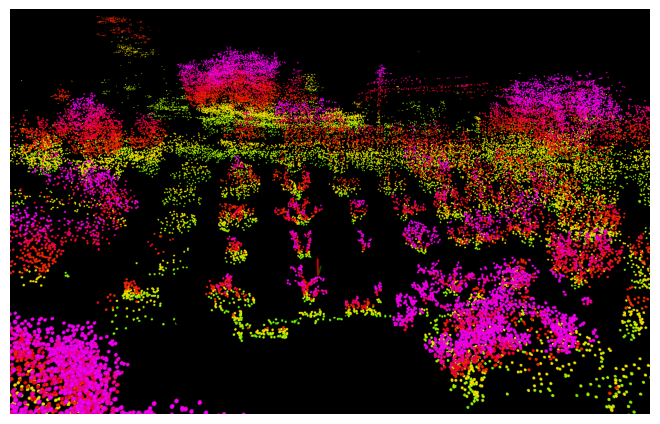

In [2]:
image_c0 = cv.imread('results_pullally_v0\pullally_aloam_iso_map_begining.png')
plt.imshow(image_c0)


# Convert to HSV for better color segmentation
hsv = cv.cvtColor(image_c0, cv.COLOR_BGR2HSV)

# Define red color range (two ranges for red in HSV)
lower_red1 = np.array([0, 100, 100])
upper_red1 = np.array([70, 255, 255])

# Create masks
mask_red1 = cv.inRange(hsv, lower_red1, upper_red1)

# Remove red and yellow by setting pixels to black
image_c0[mask_red1 > 0] = [0, 0, 0]
plt.axis("off")
plt.margins(0)
plt.gca().set_position([0, 0, 1, 1])  # Expand the image to fill the figure
plt.imshow(image_c0)
#plt.savefig("results_pullally_v0/map_loam_pulla_iso_view.pdf", dpi=300, bbox_inches="tight", pad_inches=0, transparent=True)
print(image_c0.shape)

## img 1

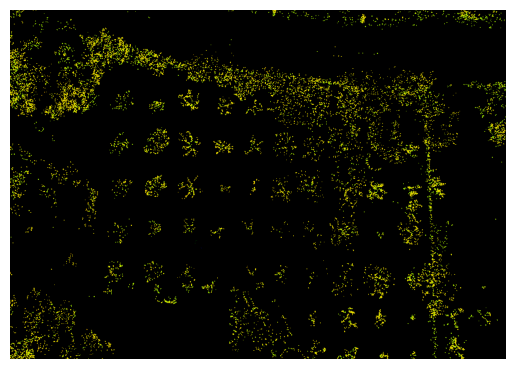

In [2]:
image_c1 = cv.imread('results_pullally_v0\pullally_aloam_up_beginig.png')
plt.imshow(image_c1)


# Convert to HSV for better color segmentation
hsv = cv.cvtColor(image_c1, cv.COLOR_BGR2HSV)

# Define red color range (two ranges for red in HSV)
lower_red1 = np.array([0, 100, 100])
upper_red1 = np.array([80, 255, 255])
lower_red2 = np.array([100, 100, 100])
upper_red2 = np.array([255, 255, 255])

# Create masks
mask_red1 = cv.inRange(hsv, lower_red1, upper_red1)
mask_red2 = cv.inRange(hsv, lower_red2, upper_red2)

# Combine red masks
mask = mask_red1 | mask_red2

# Remove red and yellow by setting pixels to black
image_c1[mask > 0] = [0, 0, 0]
plt.axis("off")
plt.imshow(image_c1)

In [3]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv.INTER_LINEAR)
  return result

def cut_map (map_data):
    y1, y2, x1,x2 = 80, -1,140,840
    return map_data[y1:y2, x1:x2]

def binary_map (map_data, treshold = 0.7):
    img2 = np.where(map_data > treshold, 255, 0)
    img2 = np.array(img2,np.uint8)
    #plt.imshow(img2)#,interpolation='nearest')#, extent = [0, XMAX, 0, YMAX])
    #plt.show()
    return img2

def normalize_array(arr):
    norm_arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
    return norm_arr

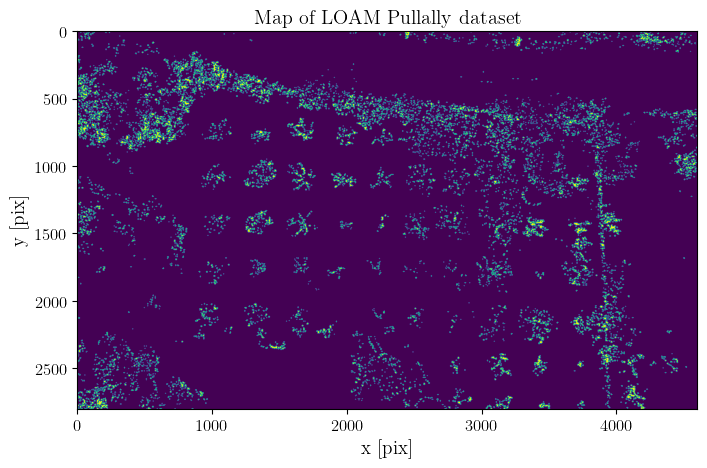

In [ ]:
fig, ax = plt.subplots()
img_map_log = rotate_image(image_c1,0)#cut_map(rotate_image(image_c,1))
gray_image = cv.cvtColor(img_map_log, cv.COLOR_BGR2GRAY)
map_normalized = normalize_array(gray_image)   
img_map = cv.resize(binary_map (map_normalized, treshold = 0.01), (4600, 2800))
plt.imshow(img_map)
plt.title("Map of LOAM Pullally dataset")
plt.xlabel("x [pix]")
plt.ylabel("y [pix]")
fig.set_size_inches(8, 8, forward=True)
plt.savefig("results_pullally_v0/map_loam_pullally0.pdf", dpi=300, bbox_inches="tight")

## img 2

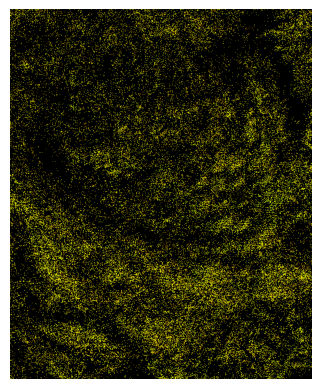

In [2]:
image_c2 = cv.imread('results_pullally_v0\pullaly_aloam_up_map_end.png')
plt.imshow(image_c2)


# Convert to HSV for better color segmentation
hsv = cv.cvtColor(image_c2, cv.COLOR_BGR2HSV)

# Define red color range (two ranges for red in HSV)
lower_red1 = np.array([0, 100, 100])
upper_red1 = np.array([80, 255, 255])
lower_red2 = np.array([100, 100, 100])
upper_red2 = np.array([255, 255, 255])

# Create masks
mask_red1 = cv.inRange(hsv, lower_red1, upper_red1)
mask_red2 = cv.inRange(hsv, lower_red2, upper_red2)

# Combine red masks
mask = mask_red1 | mask_red2

# Remove red and yellow by setting pixels to black
image_c2[mask > 0] = [0, 0, 0]
plt.axis("off")
plt.imshow(image_c2)

In [3]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv.INTER_LINEAR)
  return result

def cut_map (map_data):
    y1, y2, x1,x2 = 80, -1,140,840
    return map_data[y1:y2, x1:x2]

def binary_map (map_data, treshold = 0.7):
    img2 = np.where(map_data > treshold, 255, 0)
    img2 = np.array(img2,np.uint8)
    #plt.imshow(img2)#,interpolation='nearest')#, extent = [0, XMAX, 0, YMAX])
    #plt.show()
    return img2

def normalize_array(arr):
    norm_arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
    return norm_arr

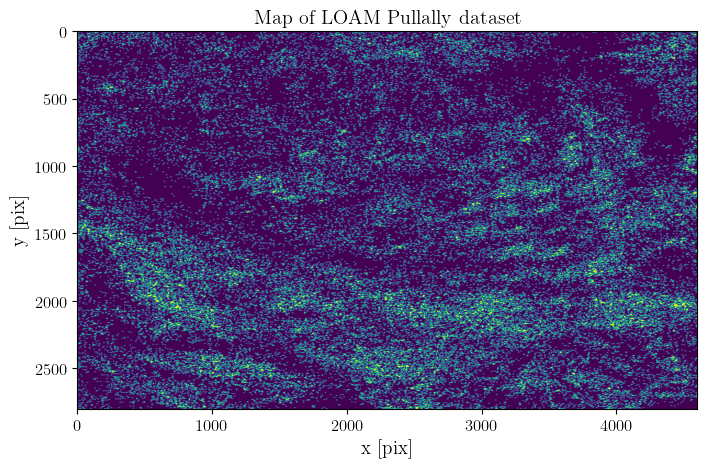

In [5]:
fig, ax = plt.subplots()
img_map_log = rotate_image(image_c2,0)#cut_map(rotate_image(image_c,1))
gray_image = cv.cvtColor(img_map_log, cv.COLOR_BGR2GRAY)
map_normalized = normalize_array(gray_image)   
img_map = cv.resize(binary_map (map_normalized, treshold = 0.01), (4600, 2800))
plt.imshow(img_map)
plt.title("Map of LOAM Pullally dataset")
plt.xlabel("x [pix]")
plt.ylabel("y [pix]")
fig.set_size_inches(8, 8, forward=True)
plt.savefig("results_pullally_v0/map_loam_pullally2.pdf", dpi=300, bbox_inches="tight")

## img 3

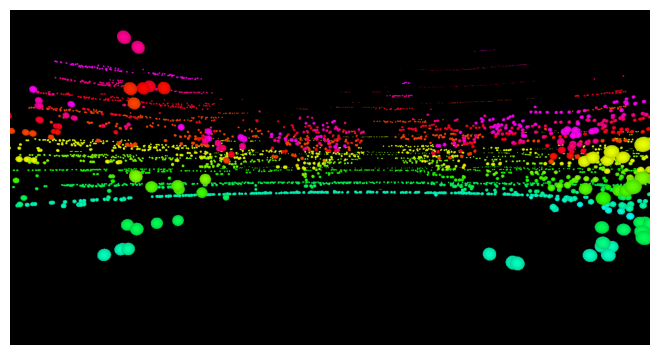

In [10]:
image_c3 = cv.imread('results_pullally_v0\pullally_front_view0.png')
plt.imshow(image_c3)


# Convert to HSV for better color segmentation
hsv = cv.cvtColor(image_c3, cv.COLOR_BGR2HSV)

# Define red color range (two ranges for red in HSV)
lower_red1 = np.array([0, 100, 100])
upper_red1 = np.array([30, 255, 255])

# Create masks
mask_red1 = cv.inRange(hsv, lower_red1, upper_red1)

# Remove red and yellow by setting pixels to black
image_c3[mask_red1 > 0] = [0, 0, 0]
plt.axis("off")
plt.margins(0)
plt.gca().set_position([0, 0, 1, 1])  # Expand the image to fill the figure
plt.imshow(image_c3)
#plt.savefig("results_pullally_v0/map_pulla_front_view0.pdf", dpi=300, bbox_inches="tight", pad_inches=0, transparent=True)

In [11]:
print(image_c3.shape)

(752, 1435, 3)


# 22 march

In [1]:
import numpy as np
import cv2 as cv
import math
import matplotlib.pyplot as plt
from generate_data_v4.plot_functions import subplot_2fig
from generate_data_v4.function_generate_v4 import obtain_data, obtain_uv
from matplotlib.ticker import AutoMinorLocator, FixedLocator
# Configurar Matplotlib para usar LaTeX con Times New Roman
plt.rcParams.update({
    "text.usetex": True,  # Usar LaTeX para renderizar texto
    "font.family": "serif",  # Familia de fuente serif
    "font.serif": ["Times New Roman"],  # ["Computer Modern"] Especificar Times New Roman
    "axes.labelsize": 14,  # Tamaño de etiquetas
    "font.size": 12  # Tamaño de fuente general
})

In [2]:
def arrange_loam_list_v0 (file_npz):
    #['time_gnss', 'gnss_data', 'time_scan0', 'scan0', 'time_loam', 'odom_loam']
    #print(file_npz.files)
    t_gnss = file_npz["time_gnss"]
    gnss_data = file_npz["gnss_data"]
    t_loam = file_npz['time_loam']
    o_loam= file_npz['odom_loam']
    return [t_gnss, gnss_data, t_loam, o_loam ]


def data2dict_loam_data (file_path):
    name_data = np.load('data_pullally/' + str(file_path))
    list_data = arrange_loam_list_v0(name_data)
    #map_log, map_occ
    key_list = ['t_gnss','gnss', 't_loam' , 'o_loam']
    my_dict = {}
    for index, element in zip(key_list, list_data):
        my_dict[index] = element
    return my_dict

def get_loam_datasets(list_files):
    lis_dictionaries = []
    for data in list_files:
        dic_data = data2dict_loam_data (data)
        lis_dictionaries.append(dic_data)
    return lis_dictionaries

uv_generator = obtain_uv()

## Loam

In [5]:
name_loam_datasets = ['D1_v0.npz','D2_v0.npz', 'D3_v0.npz']
list_loam_datasets = get_loam_datasets(name_loam_datasets)

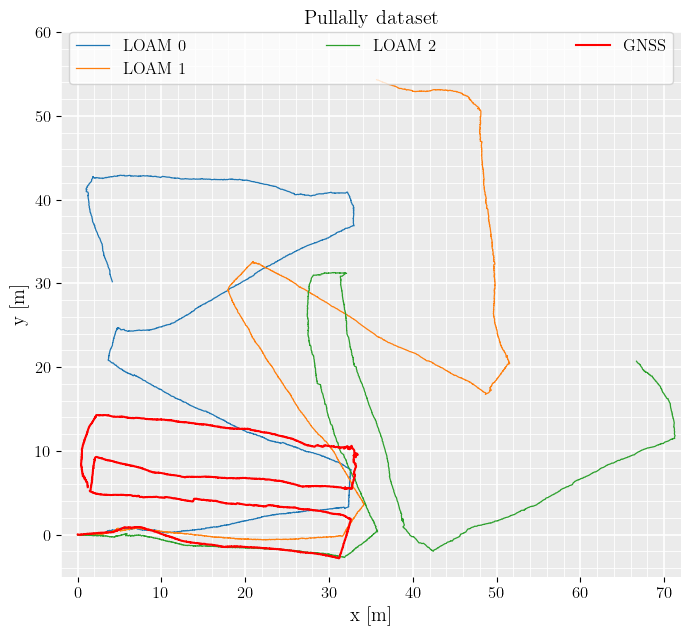

In [4]:
rotations=[-0.1,-0.08, 0.0]
aux = 0
cut_data =2538
aux = 0
fig, ax = plt.subplots()
l1,l2,l3 = 100, 0,2538 #500,550,1000
for i,j in zip(list_loam_datasets, rotations):  
    data_gnss, data_loam = i['gnss'], i['o_loam']
    gnss_new_xy = uv_generator.change2world_frame(data_gnss, j)
    ax.plot(data_loam[:,:1], data_loam[:,1:2], linewidth=0.9, label= 'LOAM '+str(aux))
    #print(data_loam.shape, gnss_new_xy.shape)
    if aux == 0:
        list_y = np.array(data_loam[:cut_data,1:2])
        list_x = np.array(data_loam[:cut_data,:1])
        data_loam0 = i['o_loam']
    else:
        list_y = np.concatenate ((list_y,data_loam[:cut_data,1:2]), axis=1)
        list_x = np.concatenate ((list_x,data_loam[:cut_data,:1]), axis=1)
    #plot_2sets(data_loam, gnss_new_xy)
    aux = aux+1

ax.plot(gnss_new_xy [:,:1], gnss_new_xy [:,1:2], 'r', label= 'GNSS ')

ax.set_facecolor('#EBEBEB')
# Remove border around plot.
[ax.spines[side].set_visible(False) for side in ax.spines]
# Style the grid.
ax.grid(which='major', color='white', linewidth=1.2)
ax.grid(which='minor', color='white', linewidth=0.6)

# Show the minor ticks and grid.
ax.minorticks_on()
# Now hide the minor ticks (but leave the gridlines).
ax.tick_params(which='minor', bottom=False, left=False)

ax.xaxis.set_major_locator(FixedLocator(np.arange(0, 80, 10)))
ax.yaxis.set_major_locator(FixedLocator(np.arange(0, 70, 10)))
ax.set_aspect('equal')
ax.set_aspect(1)  # Ensures equal scaling
#plt.legend(loc='upper right')
#plt.legend(bbox_to_anchor=(1.14,1.14), loc="upper right")
plt.legend(bbox_to_anchor=(0, 0.89, 1, 0), loc="lower left", mode="expand", ncol=3)
plt.title("Pullally dataset")
plt.xlabel("x [m]")
plt.ylabel("y [m]")

plt.ylim(-5., 60.)
#plt.xlim(-0.5,7)
plt.xlim(-2,72.)

fig.set_size_inches(8, 8, forward=True)
#fig.set_figheight(5, forward=True)

plt.savefig("results_pullally_v0/pullally_results_loam.pdf", dpi=300, bbox_inches="tight")#, transparent=True)

plt.show()

## Our

In [3]:
def arrange_our_list_v0 (file_npz):
    #['gnss_cones', 'gnss_rotated', 'hausdorff_medido', 'estimado', 'predicho', 'real', 'map_log', 'map_occ', 'mean_hauss', 'error_x', 'pk', 'lista_e', 'lista_ll', 'limits_filters', 'k_losts', 'count_n', 'segment_list', 'dictionary', 'dic_aux', 'reference', 'm_slope', 'P_filter', 'l_error_ok', 'time_d_loam', 'odom_sinc_loam']
    #print(file_npz.files)
    #t_gnss = file_npz["time_gnss"]
    gnss_data = file_npz["gnss_cones"]
    #t_loam = file_npz['time_loam']
    o_our= file_npz['estimado']
    map_log = file_npz['map_log']
    map_occ = file_npz['map_occ']
    return [gnss_data, o_our, map_log, map_occ]

def data2dict_our_data (file_path):
    name_data = np.load('results_pullally_v0/' + str(file_path))
    list_data = arrange_our_list_v0(name_data)
    #map_log, map_occ
    key_list = ['gnss', 'o_our', 'map_our', 'map_log']
    my_dict = {}
    for index, element in zip(key_list, list_data):
        my_dict[index] = element
    return my_dict

def get_our_datasets(list_files):
    lis_dictionaries = []
    for data in list_files:
        dic_data = data2dict_our_data (data)
        lis_dictionaries.append(dic_data)
    return lis_dictionaries

In [4]:
name_our_datasets = ['exp_pullally_d2_554.npz', 'exp_pullally_d3_526.npz', 'exp_pullally_d1_540.npz']  
list_our_datasets = get_our_datasets(name_our_datasets)

(554, 3) (555, 2)
(528, 3) (529, 2)
(546, 3) (546, 2)


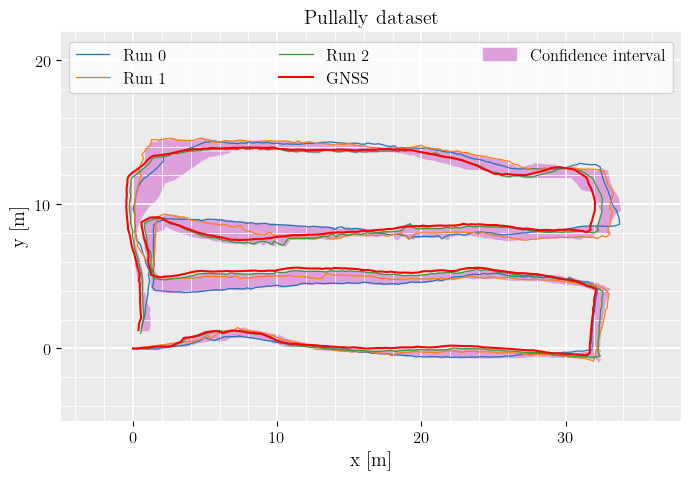

In [5]:
rotations=[ -0.03, -0.2, -0.08]
aux = 0
cut_data0, cut_data1 = 520, 546
aux = 0
fig, ax = plt.subplots()
l1,l2, l3 = 500, 400, 489 #500,550,1000
for i,j in zip(list_our_datasets, rotations):  
    data_gnss, data_our = i['gnss'], i['o_our']
    gnss_new_xy = uv_generator.change2world_frame(data_gnss, -0.1)
    data_our_xy = uv_generator.change2world_frame(data_our, j)
    ax.plot(data_our_xy[:,:1], data_our_xy[:,1:2], linewidth=0.9, label= 'Run '+str(aux))
    print(data_our.shape, gnss_new_xy.shape)
    if aux == 0:
        list_y0 = np.array(data_our_xy[:cut_data0,1:2])
        list_x0 = np.array(data_our_xy[:cut_data0,:1])
        list_y1 = np.array(data_our_xy[:cut_data1,1:2])
        list_x1 = np.array(data_our_xy[:cut_data1,:1])
    if aux == 1:
        list_y0 = np.concatenate ((list_y0,data_our_xy[:cut_data0,1:2]), axis=1)
        list_x0 = np.concatenate ((list_x0,data_our_xy[:cut_data0,:1]), axis=1)
    if aux == 2:
        list_y0 = np.concatenate ((list_y0,data_our_xy[:cut_data0,1:2]), axis=1)
        list_x0 = np.concatenate ((list_x0,data_our_xy[:cut_data0,:1]), axis=1)
        list_y1 = np.concatenate ((list_y1,data_our_xy[:cut_data1,1:2]), axis=1)
        list_x1 = np.concatenate ((list_x1,data_our_xy[:cut_data1,:1]), axis=1)
    #plot_2sets(data_loam, gnss_new_xy)
    aux = aux+1

ax.plot(gnss_new_xy [:,:1], gnss_new_xy [:,1:2], 'r', label= 'GNSS ')

Y1min = np.min(list_y0[:l1], axis=1)
Y1max = np.max(list_y0[:l1], axis=1)
X1min = np.min(list_x0[:l2], axis=1)
X1max = np.max(list_x0[:l2], axis=1)
X2min = np.min(list_x1[l3:cut_data1], axis=1)
X2max = np.max(list_x1[l3:cut_data1], axis=1)

ax.fill_between(data_our_xy [:l1,0], Y1max, Y1min, color="plum", label= 'Confidence interval ')
ax.fill_betweenx(data_our_xy[:l2,1], X1max, X1min, color="plum")
ax.fill_betweenx(gnss_new_xy[l3:cut_data1,1], X2max, X2min, color="plum")

ax.set_facecolor('#EBEBEB')
# Remove border around plot.
[ax.spines[side].set_visible(False) for side in ax.spines]
# Style the grid.
ax.grid(which='major', color='white', linewidth=1.2)
ax.grid(which='minor', color='white', linewidth=0.6)

# Show the minor ticks and grid.
ax.minorticks_on()
# Now hide the minor ticks (but leave the gridlines).
ax.tick_params(which='minor', bottom=False, left=False)

ax.xaxis.set_major_locator(FixedLocator(np.arange(-20, 80, 10)))
ax.yaxis.set_major_locator(FixedLocator(np.arange(-20, 70, 10)))
ax.set_aspect('equal')
ax.set_aspect(1)  # Ensures equal scaling
#plt.legend(loc='upper right')
#plt.legend(bbox_to_anchor=(1.14,1.14), loc="upper right")

#plt.legend(bbox_to_anchor=(0, 0.89, 1, 0), loc="lower left", mode="expand", ncol=3)
plt.legend(bbox_to_anchor=(0, 0.82, 1, 0), loc="lower left", mode="expand", ncol=3)
plt.title("Pullally dataset")
plt.xlabel("x [m]")
plt.ylabel("y [m]")

#plt.ylim(-25., 40.)
#plt.xlim(-22,52.)
plt.ylim(-5., 22.)
plt.xlim(-5,38.)

fig.set_size_inches(8, 8, forward=True)
#fig.set_figheight(5, forward=True)

plt.savefig("results_pullally_v0/pullally_results_our1.pdf", dpi=300, bbox_inches="tight")#, transparent=True)

plt.show()

In [6]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv.INTER_LINEAR)
  return result

def cut_map (map_data):
    y1, y2, x1,x2 = 200, 3000,1200, 5800
    return map_data[y1:y2, x1:x2]

def binary_map (map_data, treshold = 0.7):
    img2 = np.where(map_data > treshold, 255, 0)
    img2 = np.array(img2,np.uint8)
    #plt.imshow(img2)#,interpolation='nearest')#, extent = [0, XMAX, 0, YMAX])
    #plt.show()
    return img2

def normalize_array(arr):
    norm_arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
    return norm_arr

NameError: name 'fig' is not defined

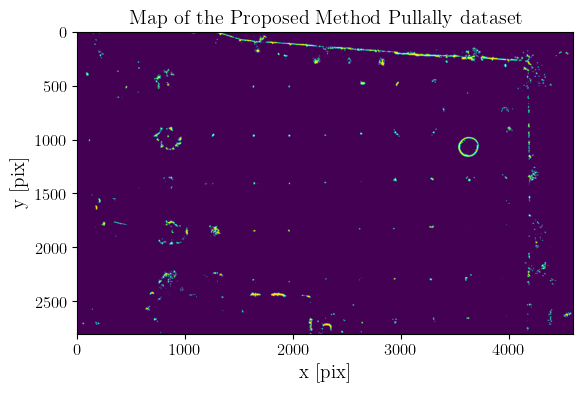

In [ ]:
fig, ax = plt.subplots()
img_map_log = cut_map (rotate_image(list_our_datasets[0]['map_log'], 2))#img_map_log[200:3000,1200:5800]
log_map_normalized = normalize_array(img_map_log)     # print(np.min(log_map_normalized), np.max(log_map_normalized))
img_map = binary_map (log_map_normalized, treshold = 0.5)
plt.imshow(img_map) 
plt.title("Map of the Proposed Method Pullally dataset")
plt.xlabel("x [pix]")
plt.ylabel("y [pix]")
fig.set_size_inches(8, 8, forward=True)
plt.savefig("results_pullally_v0/map_our_pullally2.pdf", dpi=300, bbox_inches="tight")
print(img_map.shape)

In [7]:
print(img_map.shape)

(2800, 4600)


In [ ]:
name_our_datasets_0 = ['exp_pullally_d1_280.npz', 'exp_pullally_d2_300.npz', 'exp_pullally_d3_304.npz']  
list_our_datasets_0 = get_our_datasets(name_our_datasets_0)

(2800, 4600)


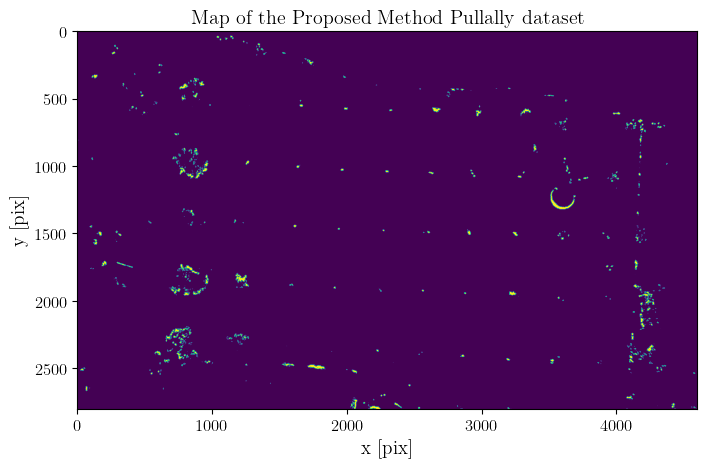

In [ ]:
fig, ax = plt.subplots()
img_map_log = cut_map (rotate_image(list_our_datasets_0[0]['map_log'], 2))#img_map_log[200:3000,1200:5800]
log_map_normalized = normalize_array(img_map_log)     # print(np.min(log_map_normalized), np.max(log_map_normalized))
img_map = binary_map (log_map_normalized, treshold = 0.5)
plt.imshow(img_map) 
plt.title("Map of the Proposed Method Pullally dataset")
plt.xlabel("x [pix]")
plt.ylabel("y [pix]")
fig.set_size_inches(8, 8, forward=True)
plt.savefig("results_pullally_v0/map_our_pullally0.pdf", dpi=300, bbox_inches="tight")
print(img_map.shape)

# results Pullaly

## Slam results

### functions

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from generate_data_v4.plot_functions import subplot_2fig
from generate_data_v4.function_generate_v4 import obtain_data, obtain_uv

In [2]:
uv_generator = obtain_uv()
# absolute error
def error_abs_pos(data_real, data_estimado):
    error_list = []
    for i in range(len(data_estimado)):
        error_a = np.array(data_real[i] - data_estimado[i])
        e_a = math.sqrt(error_a[0]**2 + error_a[1]**2)
        error_list.append([e_a, abs(error_a[2])])
    return np.array(error_list)

def error_abs_dist(data_real, data_estimado):
    error_list = []
    for i in range(len(data_estimado)):
        error_a = np.array(data_real[i] - data_estimado[i])
        error_list.append([abs(error_a[0]), abs(error_a[1])])
    return np.array(error_list)

def e_mean (eror_array):
    n = len(eror_array)
    for i in range(n):
        if i == 0:
            sum = eror_array[i]
        else:
            sum = sum + eror_array[i]
    return sum/n

def e_rms (eror_array):
    n = len(eror_array)
    for i in range(n):
        if i == 0:
            sum = np.power(eror_array[i],2)
        else:
            sum = sum + np.power(eror_array[i],2)
    return np.sqrt(sum/n)



### Aloam

In [38]:
def arrange_loam_list_v0 (file_npz):
    #['time_gnss', 'gnss_data', 'time_scan0', 'scan0', 'time_loam', 'odom_loam']
    #print(file_npz.files)
    t_gnss = file_npz["time_gnss"]
    gnss_data = file_npz["gnss_data"]
    t_loam = file_npz['time_loam']
    o_loam= file_npz['odom_loam']
    return [t_gnss, gnss_data, t_loam, o_loam ]


def data2dict_loam_data (file_path):
    name_data = np.load('data_pullally/' + str(file_path))
    list_data = arrange_loam_list_v0(name_data)
    #map_log, map_occ
    key_list = ['t_gnss','gnss', 't_loam' , 'o_loam']
    my_dict = {}
    for index, element in zip(key_list, list_data):
        my_dict[index] = element
    return my_dict

def get_loam_datasets(list_files):
    lis_dictionaries = []
    for data in list_files:
        dic_data = data2dict_loam_data (data)
        lis_dictionaries.append(dic_data)
    return lis_dictionaries

In [39]:
name_loam_datasets = ['D1_v0.npz','D2_v0.npz', 'D3_v0.npz']
list_loam_datasets = get_loam_datasets(name_loam_datasets)

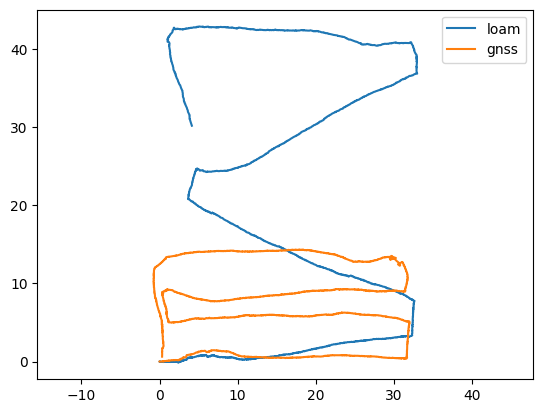

(4909, 3) (2538, 3)
(2538, 2)
(4908, 2) (2537, 2)


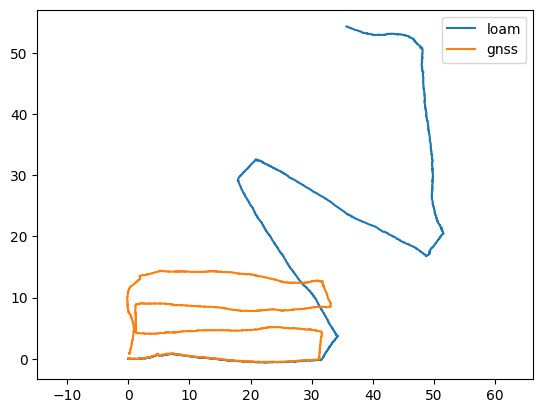

(4982, 3) (3213, 3)
(2538, 2) (3213, 2)
(4981, 2) (3212, 2)


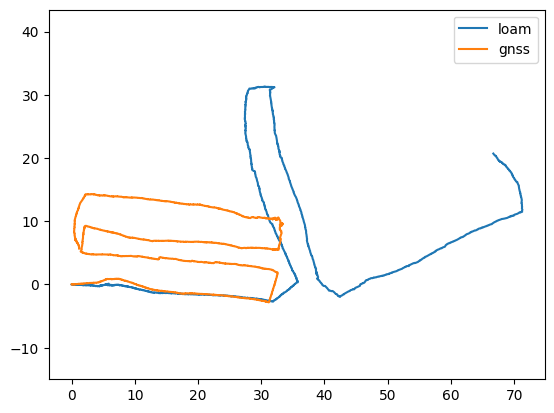

(4854, 3) (2651, 3)
(5751, 2) (2651, 2)
(4853, 2) (2650, 2)


In [45]:
def plot_2sets(set1, set2):
    plt.plot(set1[:,:1], set1[:,1:2], label= 'loam')
    plt.plot(set2[:,:1], set2[:,1:2], label= 'gnss')
    plt.legend(loc='upper right')
    plt.axis('equal')
    plt.show()

rotations=[-0.1,-0.08, 0.0]
aux = 0
for i,j in zip(list_loam_datasets, rotations):  
    data_gnss, data_loam = i['gnss'], i['o_loam']
    gnss_new_xy = uv_generator.change2world_frame(data_gnss, j)
    plot_2sets(data_loam, gnss_new_xy)

    pose_new_gnss = uv_generator.find_pose(gnss_new_xy)
    pose_new_loam = uv_generator.find_pose(data_loam)

    state_gnss_vectors = np.concatenate((gnss_new_xy, pose_new_gnss), axis=1)
    state_loam_vestors = np.concatenate((data_loam[:,:2], pose_new_loam), axis=1)
    print(state_gnss_vectors.shape, state_loam_vestors.shape)
    delta_theta_gnss = uv_generator.odom_theta(pose_new_gnss)
    delta_d_gnss = uv_generator.odom_distance(state_gnss_vectors[:,:2] )
    
    delta_theta_loam = uv_generator.odom_theta(pose_new_loam)
    delta_d_loam = uv_generator.odom_distance(state_loam_vestors[:,:2] )

    e_abs_list = error_abs_pos(state_gnss_vectors, state_loam_vestors)
    delta_gnss_vectors = np.stack((delta_d_gnss, delta_theta_gnss), axis=1)
    delta_loam_vectors = np.stack((delta_d_loam, delta_theta_loam), axis =1)
    if aux == 0:
        list_all_errors = e_abs_list
        list_d_gnss = delta_gnss_vectors
        list_d_loam = delta_loam_vectors
        lista_pn = np.array([e_abs_list[-1][0]])#np.array([state_gnss_vectors[-1] - state_loam_vestors[-1]])
        print(list_all_errors.shape)
    else:
        print(list_all_errors.shape, e_abs_list.shape)
        list_all_errors = np.concatenate((list_all_errors, e_abs_list))
        list_d_gnss = np.concatenate ((list_d_gnss, delta_gnss_vectors))
        list_d_loam = np.concatenate((list_d_loam, delta_loam_vectors))
        lista_pn = np.concatenate((lista_pn, np.array([e_abs_list[-1][0]])))#((lista_pn,np.array([state_gnss_vectors[-1]- state_loam_vestors[-1]])), axis=0)
    aux = aux +1
    
    print(delta_gnss_vectors.shape, delta_loam_vectors.shape)


In [50]:
rms_errors = e_rms(list_all_errors)
print(e_mean(list_all_errors), rms_errors)
print(" mean pos : " + "%.4f"%np.mean(list_all_errors[:,0] ) +  "   std pos :"+ "%.4f"%np.std(list_all_errors [:,0])+ "   c pos :"+ "%.4f"%((1.96/5)*np.std(list_all_errors [:,0])))
print(" mean ang : " + "%.4f"%np.mean(list_all_errors[:,1] ) +  "   std ang :"+ "%.4f"%np.std(list_all_errors[:,1])+ "   c pos :"+ "%.4f"%((1.96/5)*np.std(list_all_errors [:,1])))
print(" rms pos : " + "%.4f"%(rms_errors[0] ) +  "    rms ang :"+ "%.4f"%(rms_errors[1]))
print("%.2f"%np.mean(list_all_errors[:,0] ) +  " $\pm$ "+ "%.2f"%((1.96/np.sqrt(3))*np.std(list_all_errors [:,0])) +" & " + "%.2f"%np.mean(list_all_errors[:,1] ) +  " $\pm$ "+ "%.2f"%((1.96/np.sqrt(3))*np.std(list_all_errors [:,1])) + " & " + "%.2f"%(rms_errors[0] ) +  " & "+ "%.2f"%(rms_errors[1]))

[19.80926135  3.06763255] [26.61427111  3.85156745]
 mean pos : 19.8093   std pos :17.7739   c pos :6.9674
 mean ang : 3.0676   std ang :2.3290   c pos :0.9130
 rms pos : 26.6143    rms ang :3.8516
19.81 $\pm$ 20.11 & 3.07 $\pm$ 2.64 & 26.61 & 3.85


In [51]:
e_a_loam_odom = error_abs_dist(list_d_gnss, list_d_loam)
rms_errors_o = e_rms(e_a_loam_odom)
print(e_mean(e_a_loam_odom), rms_errors_o)
print(" mean pos : " + "%.4f"%np.mean(e_a_loam_odom[:,0] ) +  "   std pos :"+ "%.4f"%np.std(e_a_loam_odom [:,0])+ "   c pos :"+ "%.4f"%((1.96/5)*np.std(e_a_loam_odom [:,0])))
print(" mean ang : " + "%.4f"%np.mean(e_a_loam_odom[:,1] ) +  "   std ang :"+ "%.4f"%np.std(e_a_loam_odom [:,1])+ "   c pos :"+ "%.4f"%((1.96/5)*np.std(e_a_loam_odom [:,1])))
print(" rms pos : " + "%.4f"%(rms_errors_o[0] ) +  "   rms ang :"+ "%.4f"%(rms_errors_o[1]))
print("%.2f"%np.mean(e_a_loam_odom[:,0] ) +  " $\pm$ "+ "%.2f"%((1.96/np.sqrt(3))*np.std(e_a_loam_odom[:,0])) +" & " + "%.2f"%np.mean(e_a_loam_odom[:,1] ) +  " $\pm$ "+ "%.2f"%((1.96/np.sqrt(3))*np.std(e_a_loam_odom [:,1])) + " & " + "%.2f"%(rms_errors_o[0] ) +  " & "+ "%.2f"%(rms_errors_o[1]))

[0.05269639 1.80875906] [0.07273544 2.31449316]
 mean pos : 0.0527   std pos :0.0501   c pos :0.0197
 mean ang : 1.8088   std ang :1.4440   c pos :0.5661
 rms pos : 0.0727   rms ang :2.3145
0.05 $\pm$ 0.06 & 1.81 $\pm$ 1.63 & 0.07 & 2.31


In [52]:
print('percentual e : ' + "%.4f"%np.mean((list_all_errors[:,0] )/sum(delta_d_gnss)) )
print('loop e : ' + "%.4f"%(np.mean(lista_pn)))

percentual e : 0.1142
loop e : 41.9932


### Our

In [53]:
def arrange_our_list_v0 (file_npz):
    #['gnss_cones', 'gnss_rotated', 'hausdorff_medido', 'estimado', 'predicho', 'real', 'map_log', 'map_occ', 'mean_hauss', 'error_x', 'pk', 'lista_e', 'lista_ll', 'limits_filters', 'k_losts', 'count_n', 'segment_list', 'dictionary', 'dic_aux', 'reference', 'm_slope', 'P_filter', 'l_error_ok', 'time_d_loam', 'odom_sinc_loam']
    #print(file_npz.files)
    #t_gnss = file_npz["time_gnss"]
    gnss_data = file_npz["gnss_cones"]
    #t_loam = file_npz['time_loam']
    o_our= file_npz['estimado']
    return [gnss_data, o_our]

def data2dict_our_data (file_path):
    name_data = np.load('results_pullally_v0/' + str(file_path))
    list_data = arrange_our_list_v0(name_data)
    #map_log, map_occ
    key_list = ['gnss', 'o_our']
    my_dict = {}
    for index, element in zip(key_list, list_data):
        my_dict[index] = element
    return my_dict

def get_our_datasets(list_files):
    lis_dictionaries = []
    for data in list_files:
        dic_data = data2dict_our_data (data)
        lis_dictionaries.append(dic_data)
    return lis_dictionaries

def plot_2sets(set1, set2, name):
    plt.plot(set1[:,:1], set1[:,1:2], label= name)
    plt.plot(set2[:,:1], set2[:,1:2], label= 'gnss')
    plt.legend(loc='upper right')
    plt.axis('equal')
    plt.show()

uv_generator = obtain_uv()

In [54]:
name_our_datasets = ['exp_pullally_d1_540.npz', 'exp_pullally_d2_554.npz', 'exp_pullally_d3_526.npz']  
list_our_datasets = get_our_datasets(name_our_datasets)

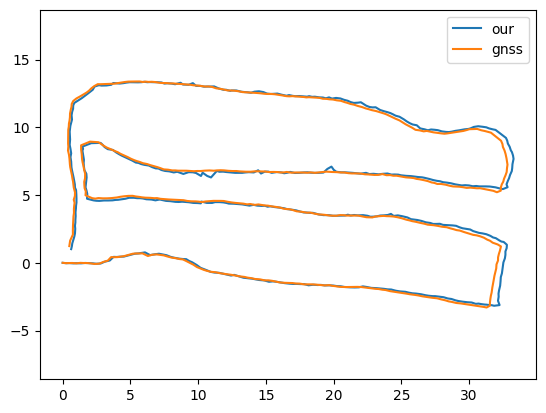

(546, 3) (546, 3)
(546, 2)


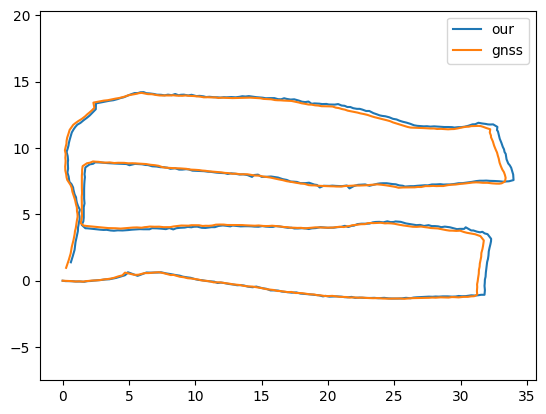

(555, 3) (554, 3)
(546, 2) (554, 2)


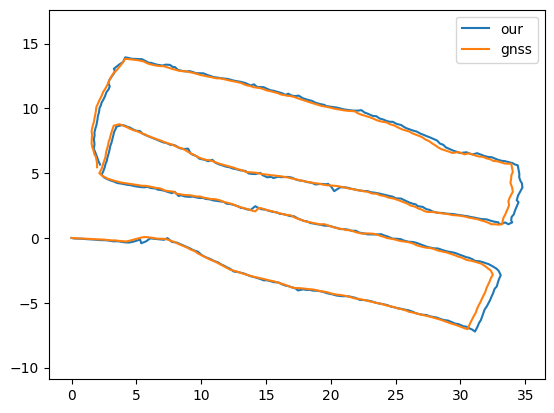

(529, 3) (528, 3)
(1100, 2) (528, 2)


In [55]:
rotations=[-0.01, -0.02, 0.06]
aux = 0
for i,j in zip(list_our_datasets, rotations):
    data_gnss = i['gnss'][:,:2]
    data_our = i['o_our']
    gnss_new = uv_generator.change2world_frame(data_gnss, j)
    plot_2sets(data_our, gnss_new, 'our')
    pose_gnss = uv_generator.find_pose(gnss_new)
    pose_our = uv_generator.find_pose(data_our)
    state_gnss_our = np.concatenate((gnss_new, pose_gnss), axis=1)
    state_our = np.concatenate((data_our[:,:2], pose_our), axis=1)
    print(state_gnss_our.shape, state_our.shape)

    delta_theta_gnss_our = uv_generator.odom_theta(pose_gnss)
    delta_d_gnss_our = uv_generator.odom_distance(state_gnss_our[:,:2] )

    delta_theta_our = uv_generator.odom_theta(pose_our)
    delta_d_our = uv_generator.odom_distance(state_our[:,:2] )

    e_abs_list_our = error_abs_pos(state_gnss_our, state_our)
    delta_gnss_our = np.stack((delta_d_gnss_our, delta_theta_gnss_our), axis=1)
    delta_our = np.stack((delta_d_our, delta_theta_our), axis =1)
    if aux == 0:
        list_all_errors_our = e_abs_list_our
        list_d_gnss_our = delta_gnss_our
        list_d_our = delta_our
        lista_pn = np.array([e_abs_list_our[-1][0]])#np.array([state_gnss_vectors[-1] - state_loam_vestors[-1]])
        print(list_all_errors_our.shape)
    else:
        print(list_all_errors_our.shape, e_abs_list_our.shape)
        list_all_errors_our = np.concatenate((list_all_errors_our, e_abs_list_our))
        list_d_gnss_our = np.concatenate ((list_d_gnss_our, delta_gnss_our))
        list_d_our = np.concatenate((list_d_our, delta_our))
        lista_pn = np.concatenate((lista_pn, np.array([e_abs_list_our[-1][0]])))#((lista_pn,np.array([state_gnss_vectors[-1]- state_loam_vestors[-1]])), axis=0)
    aux = aux +1


In [56]:
rms_errors_our = e_rms(list_all_errors_our)
print(e_mean(list_all_errors_our), rms_errors_our)
print(" mean pos : " + "%.4f"%np.mean(list_all_errors_our[:,0] ) +  "   std pos :"+ "%.4f"%np.std(list_all_errors_our [:,0])+ "   c pos :"+ "%.4f"%((1.96/4)*np.std(list_all_errors_our [:,0])))
print(" mean ang : " + "%.4f"%np.mean(list_all_errors_our[:,1] ) +  "   std ang :"+ "%.4f"%np.std(list_all_errors_our[:,1])+ "   c pos :"+ "%.4f"%((1.96/4)*np.std(list_all_errors_our [:,1])))
print(" rms pos : " + "%.4f"%(rms_errors_our[0] ) +  "    rms ang :"+ "%.4f"%(rms_errors_our[1]))
print("%.2f"%np.mean(list_all_errors_our[:,0] ) +  " $\pm$ "+ "%.2f"%((1.96/np.sqrt(3))*np.std(list_all_errors_our [:,0])) +" & " + "%.2f"%np.mean(list_all_errors_our[:,1] ) +  " $\pm$ "+ "%.2f"%((1.96/np.sqrt(3))*np.std(list_all_errors_our [:,1])) + " & " + "%.2f"%(rms_errors_our[0] ) +  " & "+ "%.2f"%(rms_errors_our[1]))

[0.33912296 0.1153875 ] [0.37482728 0.18535595]
 mean pos : 0.3391   std pos :0.1597   c pos :0.0782
 mean ang : 0.1154   std ang :0.1451   c pos :0.0711
 rms pos : 0.3748    rms ang :0.1854
0.34 $\pm$ 0.18 & 0.12 $\pm$ 0.16 & 0.37 & 0.19


In [57]:
e_a_our_odom = error_abs_dist(list_d_gnss_our, list_d_our)
rms_errors_o_our = e_rms(e_a_our_odom)
print(e_mean(e_a_our_odom), rms_errors_o_our)
print(" mean pos : " + "%.4f"%np.mean(e_a_our_odom[:,0] ) +  "   std pos :"+ "%.4f"%np.std(e_a_our_odom [:,0])+ "   c pos :"+ "%.4f"%((1.96/4)*np.std(e_a_our_odom [:,0])))
print(" mean ang : " + "%.4f"%np.mean(e_a_our_odom[:,1] ) +  "   std ang :"+ "%.4f"%np.std(e_a_our_odom [:,1])+ "   c pos :"+ "%.4f"%((1.96/4)*np.std(e_a_our_odom [:,1])))
print(" rms pos : " + "%.4f"%(rms_errors_o_our[0] ) +  "   rms ang :"+ "%.4f"%(rms_errors_o_our[1]))
print("%.2f"%np.mean(e_a_our_odom[:,0] ) +  " $\pm$ "+ "%.2f"%((1.96/np.sqrt(3))*np.std(e_a_our_odom[:,0])) +" & " + "%.2f"%np.mean(e_a_our_odom[:,1] ) +  " $\pm$ "+ "%.2f"%((1.96/np.sqrt(3))*np.std(e_a_our_odom [:,1])) + " & " + "%.2f"%(rms_errors_o_our[0] ) +  " & "+ "%.2f"%(rms_errors_o_our[1]))

[0.04094017 0.23179089] [0.06130714 0.35101776]
 mean pos : 0.0409   std pos :0.0456   c pos :0.0224
 mean ang : 0.2318   std ang :0.2636   c pos :0.1292
 rms pos : 0.0613   rms ang :0.3510
0.04 $\pm$ 0.05 & 0.23 $\pm$ 0.30 & 0.06 & 0.35


In [29]:
print('percentual e : ' + "%.4f"%np.mean((list_all_errors_our[:,0] )/sum(delta_d_gnss_our)) )
print('loop e : ' + "%.4f"%(np.mean(lista_pn)))

percentual e : 0.0023
loop e : 0.2531


## Map results